In [66]:
import random  
random.seed(42)  

import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns  

from collections import Counter  

import torch  
import torch.nn as nn  
import torch.nn.functional as F  
import torch.optim as optim  

from torch.nn import BatchNorm1d  
from torch_geometric.data import Data  
from torch_geometric.nn import GCNConv  
from torch_geometric.transforms import ToUndirected  
from torch_geometric.utils import add_self_loops  

from sklearn.metrics import roc_curve, auc, confusion_matrix  
from sklearn.preprocessing import MinMaxScaler, label_binarize

import uproot  

# Model Description:

* Num of Features: 5
* Num of Classes: 5
* Num of Layers in the Model: 5
* Num of Epochs: 300
* Loss function: nn.CrossEntropyLoss(weight=weight_tensor) where the weight tensor is given by $${weight}_i = \frac{{total\space samples}}{{frequency}_i}$$
* Optimizer: optim.Adam(model.parameters(), lr=0.01)
* Scheduler: torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
* Sampling:
True-True: 12000
Lone-Lone: 12000
Cluster-Lone: 12000
Lone-Cluster: 12000
Cluster-Cluster: 3000


In [3]:
file = uproot.open('/home/mxg1065/MyxAODAnalysis_super3D.outputs.root')
print(file.keys())

['analysis;1']


In [4]:
tree = file['analysis;1']
branches = tree.arrays()
print(tree.keys()) # Variables per event

['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'cell_z', 'cell_subCalo', 'cell_sampling', 'cell_size', 'cell_hashID', 'neighbor', 'seedCell_id', 'cell_e', 'cell_noiseSigma', 'cell_SNR', 'cell_time', 'cell_weight', 'cell_truth', 'cell_truth_indices', 'cell_shared_indices', 'cell_cluster_index', 'cluster_to_cell_indices', 'cluster_to_cell_weights', 'cell_to_cluster_e', 'cell_to_cluster_eta', 'cell_to_cluster_phi', 'cluster_eta', 'cluster_phi', 'cluster_e', 'cellsNo_cluster', 'clustersNo_event', 'jetEnergyWtdTimeAve', 'jetEta', 'jetPhi', 'jetE', 'jetPt', 'jetNumberPerEvent', 'cellIndices_per_jet']


### Prepairing the Data Dictionary

In [5]:
# 100 events and 187652 cells
# Arrays containing information about the energy, noise, snr, 
cell_e = np.array(branches['cell_e'])
cell_noise = np.array(branches['cell_noiseSigma'])
cell_snr = np.array(branches['cell_SNR'])
cell_eta = np.array(branches['cell_eta'])
cell_phi = np.array(branches['cell_phi'])

# Represents the index of the cluster that each cell corresponds to. If the index
# is 0, that means that the given cell does not belong to a cluster.
cell_to_cluster_index = np.array(branches['cell_cluster_index'])

# For each entry, contains the IDs of cells neighboring a given cell
neighbor = branches['neighbor']


In [6]:
num_of_events = len(cell_snr)
num_of_cells = len(cell_snr[0])
print("Number of Events:", num_of_events)
print("Number of Cells:", num_of_cells)

Number of Events: 100
Number of Cells: 187652


In [7]:
# We use the data arrays to crete a data dictionary, where each entry corresponds
# to the data of a given event; we scale this data.
data = {}

for i in range(num_of_events):
    data[f'data_{i}'] = np.concatenate((np.expand_dims(cell_snr[i], axis=1),
                                        np.expand_dims(cell_e[i], axis=1),
                                        np.expand_dims(cell_noise[i], axis=1),
                                        np.expand_dims(cell_eta[i], axis=1),
                                        np.expand_dims(cell_phi[i], axis=1)), axis=1)
    
# We combine the data into one array and apply the MinMaxScaler
combined_data = np.vstack([data[key] for key in data])
scaler = MinMaxScaler()
scaled_combined_data = scaler.fit_transform(combined_data)

# The scaled data is split to have the save structure as the original data dict
scaled_data = {}
start_idx = 0
for i in range(num_of_events):
    end_idx = start_idx + data[f"data_{i}"].shape[0]
    scaled_data[f"data_{i}"] = scaled_combined_data[start_idx:end_idx]
    start_idx = end_idx

print(scaled_data["data_0"])
print(scaled_data["data_0"].shape)

[[0.02640459 0.24943821 0.09700817 0.23466232 0.5085498 ]
 [0.02567646 0.24627675 0.09700815 0.23466876 0.52418756]
 [0.02508186 0.24369499 0.09700817 0.23467347 0.5398244 ]
 ...
 [0.02632877 0.24791998 0.03177016 0.62017125 0.4921177 ]
 [0.02705116 0.2511391  0.07512318 0.6461531  0.4921177 ]
 [0.02638626 0.24820389 0.04149057 0.6731673  0.4921177 ]]
(187652, 5)


### Preparing Neighbor Pairs

In [8]:
# The IDs of the broken cells (those with zero noise) are collected
broken_cells = []

for i in range(num_of_events):
    cells = np.argwhere(cell_noise[i]==0)
    broken_cells = np.squeeze(cells)

print(broken_cells)

[186986 187352]


In [9]:
# Since the values associated with neighbor[0] and neighbor[1] are all equal
# we will just work with neighbor[0] to simplify our calculations
neighbor = neighbor[0]

In [10]:
# We loop through the neighbor awkward array and remove the IDs associated
# with the broken cells.  Loops through all cells in the neighbor list. If the loop 
# reaches the cell numbers 186986 or 187352, loop skips over these inoperative cells. 
# The final list contains tuples (i,j) where i is the cell ID in question and the 
# js are the neighboring cell IDs
neighbor_pairs_list = []

for i in range(num_of_cells):
    if i in broken_cells:
        continue
    for j in neighbor[i]:
        if j in broken_cells:
            continue
        neighbor_pairs_list.append((i, int(j)))

In [11]:
# This code checks to see if the broken cells were removed
found_broken_cells = []

for pair in neighbor_pairs_list:
    # Loop through each cell in pair
    for cell in pair:
        # If the cell is broken, appends to list
        if cell in broken_cells:
            found_broken_cells.append(cell)

if found_broken_cells:
    print("Error: Broken cells are still present in neighbor pairs.")
else:
    print("Successfully excluded broken cells.")

Successfully excluded broken cells.


In [12]:
# These functions remove permutation variants
def canonical_form(t):
    return tuple(sorted(t))

def remove_permutation_variants(tuple_list):
    unique_tuples = set(canonical_form(t) for t in tuple_list)
    return [tuple(sorted(t)) for t in unique_tuples]

neighbor_pairs_list = np.array(remove_permutation_variants(neighbor_pairs_list))
print(neighbor_pairs_list)
print(neighbor_pairs_list.shape)

[[ 90345 119588]
 [  4388  17680]
 [ 39760  39825]
 ...
 [159757 168717]
 [ 62911  78974]
 [135353 135609]]
(1250242, 2)


### Plotting the Features

In [13]:
# # Initialize dictionary to store features by class
# features_by_class = {cls: {'SNR': [], 'Energy': [], 'Noise': []}
#                      for cls in range(5)}

# # Precompute features for all events in a vectorized way
# for i in range(num_of_events):  # Iterate through events
#     for pair_idx, pair in enumerate(neighbor_pairs_list):
#         class_label = labels_for_neighbor_pairs[i][pair_idx]

#         # Vectorized feature extraction for cell pairs
#         cell_1_features = [cell_SNR[i][pair[0]], cell_e[i]
#                            [pair[0]], cell_noiseSigma[i][pair[0]]]
#         cell_2_features = [cell_SNR[i][pair[1]], cell_e[i]
#                            [pair[1]], cell_noiseSigma[i][pair[1]]]

#         # Append features to the corresponding class
#         features_by_class[class_label]['SNR'] += [cell_1_features[0],
#                                                   cell_2_features[0]]
#         features_by_class[class_label]['Energy'] += [
#             cell_1_features[1], cell_2_features[1]]
#         features_by_class[class_label]['Noise'] += [cell_1_features[2],
#                                                     cell_2_features[2]]

# # Function to precompute bin edges for all features


# def precompute_bins(features_by_class, snr_xlim=None, energy_xlim=None, noise_xlim=None, bins=50):
#     bins_dict = {}

#     # Compute bins for SNR
#     if snr_xlim:
#         bins_dict['SNR'] = np.linspace(snr_xlim[0], snr_xlim[1], bins + 1)
#     else:
#         all_snr = np.concatenate([features['SNR']
#                                  for features in features_by_class.values()])
#         bins_dict['SNR'] = np.histogram_bin_edges(all_snr, bins=bins)

#     # Compute bins for Energy
#     if energy_xlim:
#         bins_dict['Energy'] = np.linspace(
#             energy_xlim[0], energy_xlim[1], bins + 1)
#     else:
#         all_energy = np.concatenate([features['Energy']
#                                     for features in features_by_class.values()])
#         bins_dict['Energy'] = np.histogram_bin_edges(all_energy, bins=bins)

#     # Compute bins for Noise
#     if noise_xlim:
#         bins_dict['Noise'] = np.linspace(
#             noise_xlim[0], noise_xlim[1], bins + 1)
#     else:
#         all_noise = np.concatenate([features['Noise']
#                                    for features in features_by_class.values()])
#         bins_dict['Noise'] = np.histogram_bin_edges(all_noise, bins=bins)

#     return bins_dict


# # Optimized function to plot histograms using precomputed bins
# def plot_histograms_optimized(features_by_class, bins_dict):
#     for class_label, features in features_by_class.items():
#         if len(features['SNR']) > 0:  # Ensure there are features to plot
#             plt.figure(figsize=(15, 5))

#             # Plot SNR histogram with precomputed bins
#             plt.subplot(1, 3, 1)
#             plt.hist(features['SNR'], bins=bins_dict['SNR'],
#                      alpha=0.6, label=f'Class {class_label}')
#             plt.xlabel('SNR')
#             plt.ylabel('Frequency')
#             plt.title(f'Class {class_label}: SNR')
#             plt.grid(True)

#             # Plot Energy histogram with precomputed bins
#             plt.subplot(1, 3, 2)
#             plt.hist(features['Energy'], bins=bins_dict['Energy'],
#                      alpha=0.6, label=f'Class {class_label}')
#             plt.xlabel('Energy')
#             plt.ylabel('Frequency')
#             plt.title(f'Class {class_label}: Energy')
#             plt.grid(True)

#             # Plot Noise histogram with precomputed bins
#             plt.subplot(1, 3, 3)
#             plt.hist(features['Noise'], bins=bins_dict['Noise'],
#                      alpha=0.6, label=f'Class {class_label}')
#             plt.xlabel('Noise')
#             plt.ylabel('Frequency')
#             plt.title(f'Class {class_label}: Noise')
#             plt.grid(True)

#             plt.tight_layout()
#             plt.suptitle(
#                 f'Feature Distributions for Class {class_label}', fontsize=16)
#             plt.subplots_adjust(top=0.85)  # Adjust title to prevent overlap
#             plt.show()


# # Precompute bins for SNR, Energy, and Noise
# bins_dict = precompute_bins(features_by_class, snr_xlim=(-6.5, 6.5),
#                             energy_xlim=(-500, 500), noise_xlim=(0, 500))

# # Call the optimized function to plot histograms
# plot_histograms_optimized(features_by_class, bins_dict)

In [14]:
# # Create a dictionary to store cluster pairs for all events
# all_events_cluster_pairs = {}

# # Loop through each event
# for i in range(num_of_events):
#     # Get the cluster indices for the current event
#     # Assuming it's a list of arrays for each event
#     cluster_cells_belong_to_event = cell_to_cluster_index[i]

#     # Map the neighbor pairs to their respective cluster indices for the current event
#     cluster_pairs = [
#         (cluster_cells_belong_to_event[pair[0]],
#          cluster_cells_belong_to_event[pair[1]])
#         for pair in neighbor_pairs_list
#     ]

#     # Store the cluster pairs for the current event
#     all_events_cluster_pairs[f"event_{i}"] = cluster_pairs

# # Now `all_events_cluster_pairs` is a dictionary containing cluster pairs for all events

# # Visualize Cluster Pairs for All Events
# # Create a 2x3 grid for the subplots
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust size as needed
# axes = axes.flatten()  # Flatten the 2x3 array for easier indexing

# # Loop over labels (0 to 4)
# for label in range(5):
#     cell1_clusters_all_events = []
#     cell2_clusters_all_events = []

#     # Process each event
#     for event_id, cluster_pairs in all_events_cluster_pairs.items():
#         # Get the labels for neighbor pairs in the current event
#         labels_for_event = labels_for_neighbor_pairs[int(
#             event_id.split("_")[1])]  # Get labels for this event

#         # Filter pairs by the current label
#         label_indices = [i for i, l in enumerate(
#             labels_for_event) if l == label]
#         pairs_for_label = [cluster_pairs[i] for i in label_indices]

#         # Separate cluster indices for plotting
#         cell1_clusters = [pair[0] for pair in pairs_for_label]
#         cell2_clusters = [pair[1] for pair in pairs_for_label]

#         # Accumulate data across events
#         cell1_clusters_all_events.extend(cell1_clusters)
#         cell2_clusters_all_events.extend(cell2_clusters)

#     # Plot for the current label
#     ax = axes[label]
#     ax.scatter(cell1_clusters_all_events, cell2_clusters_all_events,
#                label=f"Label {label}", alpha=0.5)
#     ax.set_xlabel("Cell 1 Cluster Index")
#     ax.set_ylabel("Cell 2 Cluster Index")
#     ax.set_title(f"Cluster Pairs for Label {label}")

# # Hide the last (empty) subplot if fewer than 6 subplots
# if len(axes) > 5:
#     axes[5].axis('off')

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

### Creating Labels for the Neighbor Pairs

For a given pair of cells and the IDs of the clusters that they belong to (i, j), if
1. i=j and both are nonzero, then both cells are part of the same cluster. 
    * We call these True-True pairs and label them with 1
2. i=j and both are zero, then both cells are not part of any cluster. 
    * We call these Lone-Lone pairs and label them with 0
3. i is nonzero and j=0, then cell i is part of a cluster while cell j is not. 
    * We call these Cluster-Lone pairs and label them with 2
4. i=0 and j is nonzero, then cell i is not part of a cluste while cell j is. 
    * We call these Lone-Cluster pairs and label them with 3
5. i is not the same as j and both are nonzero, then both cells are part of different clusters. 
    * We call these Cluster-Cluster pairs and label them with 4

In [15]:
# Initialize array for labels
labels_for_neighbor_pairs = np.zeros((num_of_events, len(neighbor_pairs_list)), dtype=int)

# Extracting the individual cells within a cell pair
cell_0 = cell_to_cluster_index[:, neighbor_pairs_list[:, 0]]
cell_1 = cell_to_cluster_index[:, neighbor_pairs_list[:, 1]]

# Computing labels using vectorized operations
same_cluster = cell_0 == cell_1 
both_nonzero = (cell_0 != 0) & (cell_1 != 0)

# Lone-Lone (0)
labels_for_neighbor_pairs[same_cluster & (cell_0 == 0)] = 0

# True-True (1)
labels_for_neighbor_pairs[same_cluster & (cell_0 != 0)] = 1

# Cluster-Cluster (4)
labels_for_neighbor_pairs[~same_cluster & both_nonzero] = 4

# Lone-Cluster (3)
labels_for_neighbor_pairs[~same_cluster & (cell_0 == 0) & (cell_1 != 0)] = 3

# Cluster-Lone (2)
labels_for_neighbor_pairs[~same_cluster & (cell_0 != 0) & (cell_1 == 0)] = 2

print(labels_for_neighbor_pairs.shape)
print(labels_for_neighbor_pairs)
print(np.unique(labels_for_neighbor_pairs[0]))

(100, 1250242)
[[0 0 0 ... 0 0 2]
 [3 3 0 ... 0 0 2]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 2 0 0]]
[0 1 2 3 4]


### Preparing the Data for Multi-Class Classification

In [16]:
# Here we collect the indices of the neighbor pairs by the pair type
indices_for_tt_pairs = []  # Label 1
indices_for_ll_pairs = []  # Label 0
indices_for_cl_pairs = []  # Label 2
indices_for_lc_pairs = []  # Label 3
indices_for_cc_pairs = []  # Label 4

for i in range(num_of_events):
    indices_for_tt_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 1)[0]))
    indices_for_ll_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 0)[0]))
    indices_for_cl_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 2)[0]))
    indices_for_lc_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 3)[0]))
    indices_for_cc_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 4)[0]))

In [17]:
# Here we collect the number of each pair type across the events
number_of_tt_pairs = [len(indices_for_tt_pairs[i])for i in range(num_of_events)]
number_of_ll_pairs = [len(indices_for_ll_pairs[i])for i in range(num_of_events)]
number_of_cl_pairs = [len(indices_for_cl_pairs[i])for i in range(num_of_events)]
number_of_lc_pairs = [len(indices_for_lc_pairs[i])for i in range(num_of_events)]
number_of_cc_pairs = [len(indices_for_cc_pairs[i])for i in range(num_of_events)]

In [18]:
# Here we perform a 70-30 split on the indices of neighbor pairs
training_indices_tt = indices_for_tt_pairs[:70]
training_indices_ll = indices_for_ll_pairs[:70]
training_indices_cl = indices_for_cl_pairs[:70]
training_indices_lc = indices_for_lc_pairs[:70]
training_indices_cc = indices_for_cc_pairs[:70]

testing_indices_tt = indices_for_tt_pairs[70:]
testing_indices_ll = indices_for_ll_pairs[70:]
testing_indices_cl = indices_for_cl_pairs[70:]
testing_indices_lc = indices_for_lc_pairs[70:]
testing_indices_cc = indices_for_cc_pairs[70:]

# Here we perform a 70-30 split on the number of neighbor pairs
training_num_tt = number_of_tt_pairs[:70]
training_num_ll = number_of_ll_pairs[:70]
training_num_cl = number_of_cl_pairs[:70]
training_num_lc = number_of_lc_pairs[:70]
training_num_cc = number_of_cc_pairs[:70]

testing_num_tt = number_of_tt_pairs[70:]
testing_num_ll = number_of_ll_pairs[70:]
testing_num_cl = number_of_cl_pairs[70:]
testing_num_lc = number_of_lc_pairs[70:]
testing_num_cc = number_of_cc_pairs[70:]

In [19]:
# We check the minimum number of each pair type across the events. When we
# randomly sample from the indices, if our sample is greater than the minimum
# numbers, then we will run into errors
print("Minimum number of pairs for training:")
print("True-True", min(training_num_tt))
print("Lone-Lone", min(training_num_ll))
print("Cluster-Lone", min(training_num_cl))
print("Lone-Cluster", min(training_num_lc))
print("Cluster-Cluster", min(training_num_cc))
print('\nMinimum number of pairs for testing:')
print("True-True", min(testing_num_tt))
print("Lone-Lone", min(testing_num_ll))
print("Cluster-Lone", min(testing_num_cl))
print("Lone-Cluster", min(testing_num_lc))
print("Cluster-Cluster", min(testing_num_cc))

Minimum number of pairs for training:
True-True 45600
Lone-Lone 926119
Cluster-Lone 41654
Lone-Cluster 45689
Cluster-Cluster 3334

Minimum number of pairs for testing:
True-True 51518
Lone-Lone 906630
Cluster-Lone 44444
Lone-Cluster 48069
Cluster-Cluster 4936


### Making training and testing sets

In [20]:
big_sample_num = 12000
small_sample_num = 3000

In [21]:
train_indices_tt_pairs = np.array([random.sample(row, big_sample_num) for row in training_indices_tt])
train_indices_ll_pairs = np.array([random.sample(row, big_sample_num) for row in training_indices_ll])
train_indices_cl_pairs = np.array([random.sample(row, big_sample_num) for row in training_indices_cl])
train_indices_lc_pairs = np.array([random.sample(row, big_sample_num) for row in training_indices_lc])
train_indices_cc_pairs = np.array([random.sample(row, small_sample_num) for row in training_indices_cc])
train_indices_bkg_pairs = np.concatenate([train_indices_ll_pairs,
                                          train_indices_cl_pairs,
                                          train_indices_lc_pairs,
                                          train_indices_cc_pairs], axis=1)

test_indices_tt_pairs = np.array([random.sample(row, big_sample_num) for row in testing_indices_tt])
test_indices_ll_pairs = np.array([random.sample(row, big_sample_num) for row in testing_indices_ll])
test_indices_cl_pairs = np.array([random.sample(row, big_sample_num) for row in testing_indices_cl])
test_indices_lc_pairs = np.array([random.sample(row, big_sample_num) for row in testing_indices_lc])
test_indices_cc_pairs = np.array([random.sample(row, small_sample_num) for row in testing_indices_cc])
test_indices_bkg_pairs = np.concatenate([test_indices_ll_pairs,
                                         test_indices_cl_pairs,
                                         test_indices_lc_pairs,
                                         test_indices_cc_pairs], axis=1)

print(train_indices_tt_pairs.shape)
print(train_indices_bkg_pairs.shape)
print(test_indices_tt_pairs.shape)
print(test_indices_bkg_pairs.shape)

(70, 12000)
(70, 39000)
(30, 12000)
(30, 39000)


In [22]:
total_training_indices = np.concatenate((train_indices_tt_pairs, train_indices_bkg_pairs), axis=1)
total_testing_indices = np.concatenate((test_indices_tt_pairs, test_indices_bkg_pairs), axis=1)
print(total_training_indices.shape)
print(total_testing_indices.shape)

(70, 51000)
(30, 51000)


### Randomizing the indicies and creating labels for training and testing

In [23]:
# Creating training labels
labels_tt_train = np.ones((70, big_sample_num), dtype=int)  # True-True
labels_ll_train = np.zeros((70, big_sample_num), dtype=int)  # Lone-Lone
labels_cl_train = np.ones((70, big_sample_num), dtype=int)*2  # Cluster-Lone
labels_lc_train = np.ones((70, big_sample_num), dtype=int)*3  # Lone-Cluster
labels_cc_train = np.ones((70, small_sample_num), dtype=int)*4  # Cluster-Cluster
labels_bkg_train = np.concatenate((labels_ll_train, labels_cl_train, labels_lc_train, labels_cc_train), axis=1)
labels_training = np.concatenate((labels_tt_train, labels_bkg_train), axis=1)

# Creating testing labels
labels_tt_test = np.ones((30, big_sample_num), dtype=int)  # True-True
labels_ll_test = np.zeros((30, big_sample_num), dtype=int)  # Lone-Lone
labels_cl_test = np.ones((30, big_sample_num), dtype=int)*2  # Cluster-Lone
labels_lc_test = np.ones((30, big_sample_num), dtype=int)*3  # Lone-Cluster
labels_cc_test = np.ones((30, small_sample_num), dtype=int)*4  # Cluster-Cluster
labels_bkg_test = np.concatenate((labels_ll_test, labels_cl_test, labels_lc_test, labels_cc_test), axis=1)
labels_testing = np.concatenate((labels_tt_test, labels_bkg_test), axis=1)

# Printing the shapes of the final training and testing labels
print(labels_training.shape)
print(labels_testing.shape)

(70, 51000)
(30, 51000)


In [24]:
# Here we randomize the training and testing information. But to do this, while keeping
# the same permutation for both indicies and labels, we use np.random.permutation

# Randomizing training data via iteration over the rows
for i in range(total_training_indices.shape[0]):
    perm = np.random.permutation(total_training_indices.shape[1])
    total_training_indices[i] = total_training_indices[i, perm]
    labels_training[i] = labels_training[i, perm]

# Randomizing testing data via iteration over the rows
for i in range(total_testing_indices.shape[0]):
    perm = np.random.permutation(total_testing_indices.shape[1])
    total_testing_indices[i] = total_testing_indices[i, perm]
    labels_testing[i] = labels_testing[i, perm]

print(total_training_indices.shape)
print(labels_training.shape)
print(total_testing_indices.shape)
print(labels_testing.shape)

(70, 51000)
(70, 51000)
(30, 51000)
(30, 51000)


In [25]:
# Arranging the neighbor pairs with the training indices
total_train_neighbor_random = []
for i in range(len(labels_training)):
    total_train_neighbor_random.append(neighbor_pairs_list[total_training_indices[i]])
total_train_neighbor_random = np.array(total_train_neighbor_random)
print(total_train_neighbor_random.shape)

# Arranging the neighbor pairs with the testing indices
total_test_neighbor_random = []
for i in range(len(labels_testing)):
    total_test_neighbor_random.append(neighbor_pairs_list[total_training_indices[i]])
total_test_neighbor_random = np.array(total_test_neighbor_random)
print(total_test_neighbor_random.shape)

(70, 51000, 2)
(30, 51000, 2)


In [26]:
def createArray(input_data, num_of_data, is_source, is_bi_directional):
    # Initialize an empty list to store the output data
    data = []

    # Loop through each set of data in input_data
    for i in range(num_of_data):
        _data = []

        # Loop through each pair of data in the current data set
        for pair in input_data[i]:

            # Process data depending on is_bi_directional flag
            if is_bi_directional:
                # If is_source is True, append both elements in original order
                if is_source:
                    _data.append(pair[0])
                    _data.append(pair[1])
                else:
                    # If is_source is False, append elements in reversed order
                    _data.append(pair[1])
                    _data.append(pair[0])
            else:
                # If is_bi_directional is False, append only one element depending on is_source flag
                if is_source:
                    _data.append(pair[0])
                else:
                    _data.append(pair[1])

        # Add the processed data set to the output list
        data.append(_data)

    # Return the final processed list of data
    data = np.array(data)
    return data

In [27]:
# Creating bi-/uni-directional arrays for processing downstream

# Training arrays
train_edge_source_bi = createArray(total_train_neighbor_random, 70, True, True)
train_edge_dest_bi = createArray(total_train_neighbor_random, 70, False, True)
train_edge_source_uni = createArray(total_train_neighbor_random, 70, True, False)
train_edge_dest_uni = createArray(total_train_neighbor_random, 70, False, False)

# Testing arrays
test_edge_source_bi = createArray(total_test_neighbor_random, 30, True, True)
test_edge_dest_bi = createArray(total_test_neighbor_random, 30, False, True)
test_edge_source_uni = createArray(total_test_neighbor_random, 30, True, False)
test_edge_dest_uni = createArray(total_test_neighbor_random, 30, False, False)

# Printing the shapes
print(train_edge_source_bi.shape)
print(train_edge_dest_bi.shape)
print(train_edge_source_uni.shape)
print(train_edge_dest_uni.shape)
print(test_edge_source_bi.shape)
print(test_edge_dest_bi.shape)
print(test_edge_source_uni.shape)
print(test_edge_dest_uni.shape)

(70, 102000)
(70, 102000)
(70, 51000)
(70, 51000)
(30, 102000)
(30, 102000)
(30, 51000)
(30, 51000)


In [28]:
# Filtering and creating neighbor pairs sorted by the indices of each neighbor type
test_neighbor_pairs_tt = []
test_neighbor_pairs_ll = []
test_neighbor_pairs_cl = []
test_neighbor_pairs_lc = []
test_neighbor_pairs_cc = []

for i in range(len(labels_testing)):
    test_neighbor_pairs_tt.append(neighbor_pairs_list[test_indices_tt_pairs[i]])
    test_neighbor_pairs_ll.append(neighbor_pairs_list[test_indices_ll_pairs[i]])
    test_neighbor_pairs_cl.append(neighbor_pairs_list[test_indices_cl_pairs[i]])
    test_neighbor_pairs_lc.append(neighbor_pairs_list[test_indices_lc_pairs[i]])
    test_neighbor_pairs_cc.append(neighbor_pairs_list[test_indices_cc_pairs[i]])

test_neighbor_pairs_tt = np.array(test_neighbor_pairs_tt)
test_neighbor_pairs_ll = np.array(test_neighbor_pairs_ll)
test_neighbor_pairs_cl = np.array(test_neighbor_pairs_cl)
test_neighbor_pairs_lc = np.array(test_neighbor_pairs_lc)
test_neighbor_pairs_cc = np.array(test_neighbor_pairs_cc)

In [29]:
test_edge_tt_source_bi = createArray(test_neighbor_pairs_tt, 30, True, True)
test_edge_tt_dest_bi = createArray(test_neighbor_pairs_tt, 30, False, True)
test_edge_tt_source_uni = createArray(test_neighbor_pairs_tt, 30, True, False)
test_edge_tt_dest_uni = createArray(test_neighbor_pairs_tt, 30, False, False)

test_edge_ll_source_bi = createArray(test_neighbor_pairs_ll, 30, True, True)
test_edge_ll_dest_bi = createArray(test_neighbor_pairs_ll, 30, False, True)
test_edge_ll_source_uni = createArray(test_neighbor_pairs_ll, 30, True, False)
test_edge_ll_dest_uni = createArray(test_neighbor_pairs_ll, 30, False, False)

test_edge_cl_source_bi = createArray(test_neighbor_pairs_cl, 30, True, True)
test_edge_cl_dest_bi = createArray(test_neighbor_pairs_cl, 30, False, True)
test_edge_cl_source_uni = createArray(test_neighbor_pairs_cl, 30, True, False)
test_edge_cl_dest_uni = createArray(test_neighbor_pairs_cl, 30, False, False)

test_edge_lc_source_bi = createArray(test_neighbor_pairs_lc, 30, True, True)
test_edge_lc_dest_bi = createArray(test_neighbor_pairs_lc, 30, False, True)
test_edge_lc_source_uni = createArray(test_neighbor_pairs_lc, 30, True, False)
test_edge_lc_dest_uni = createArray(test_neighbor_pairs_lc, 30, False, False)

test_edge_cc_source_bi = createArray(test_neighbor_pairs_cc, 30, True, True)
test_edge_cc_dest_bi = createArray(test_neighbor_pairs_cc, 30, False, True)
test_edge_cc_source_uni = createArray(test_neighbor_pairs_cc, 30, True, False)
test_edge_cc_dest_uni = createArray(test_neighbor_pairs_cc, 30, False, False)


# Print shapes
print(test_edge_tt_source_bi.shape)
print(test_edge_tt_dest_bi.shape)
print(test_edge_tt_source_uni.shape)
print(test_edge_tt_dest_uni.shape)

(30, 24000)
(30, 24000)
(30, 12000)
(30, 12000)


## Making the features array for training and testing

In [30]:
# Here we create a rearranged dictionary from the scaled data dictionary
keys = list(scaled_data.keys())
values = list(scaled_data.values())
features_dict = dict(zip(keys, values))

# Here these features are split into training and testing sets
features_training = np.concatenate([value for key, value in list(features_dict.items())[:70]])
features_testing = np.concatenate([value for key, value in list(features_dict.items())[70:]])

In [31]:
print(features_training.shape)
print(features_testing.shape)

(13135640, 5)
(5629560, 5)


In [32]:
features_training = features_training.reshape(70, 187652, 5)
features_testing = features_testing.reshape(30, 187652, 5)

# Creation of the NN Model

In [33]:
# Make the scaled features into a torch tensor (inputs)
x_train = torch.tensor(features_training, dtype=torch.float)
x_test = torch.tensor(features_testing, dtype=torch.float)

In [34]:
# Here the correct dimension permutations are applied for the model
def make_edge_index_tensor(source, dest):
    edge_index = np.stack([np.array(source), np.array(dest)], axis=0)  # Stack into a single NumPy array
    return torch.tensor(edge_index, dtype=torch.long).permute(1, 0, 2)

# Training set (Bi-directional and Uni-directional)
train_edge_indices_bi = make_edge_index_tensor(train_edge_source_bi, train_edge_dest_bi)
train_edge_indices_uni = make_edge_index_tensor(train_edge_source_uni, train_edge_dest_uni)

print(train_edge_indices_bi.shape)
print(train_edge_indices_uni.shape)


torch.Size([70, 2, 102000])
torch.Size([70, 2, 51000])


In [35]:
edge_index_data = {
    "tt_bi": (test_edge_tt_source_bi, test_edge_tt_dest_bi),
    "tt_uni": (test_edge_tt_source_uni, test_edge_tt_dest_uni),
    "ll_bi": (test_edge_ll_source_bi, test_edge_ll_dest_bi),
    "ll_uni": (test_edge_ll_source_uni, test_edge_ll_dest_uni),
    "cl_bi": (test_edge_cl_source_bi, test_edge_cl_dest_bi),
    "cl_uni": (test_edge_cl_source_uni, test_edge_cl_dest_uni),
    "lc_bi": (test_edge_lc_source_bi, test_edge_lc_dest_bi),
    "lc_uni": (test_edge_lc_source_uni, test_edge_lc_dest_uni),
    "cc_bi": (test_edge_cc_source_bi, test_edge_cc_dest_bi),
    "cc_uni": (test_edge_cc_source_uni, test_edge_cc_dest_uni),
}

# Create and permute tensors for all edge types
edge_indices = {key: make_edge_index_tensor(sources, dests) for key, (sources, dests) in edge_index_data.items()}

In [36]:
y_train = np.expand_dims(labels_training, axis=1)
y_train = torch.tensor(y_train)
y_test = np.expand_dims(labels_testing, axis=1)
y_test = torch.tensor(y_test)

### Creation of custom data lists, collate functions, and data loaders

In [37]:
# Create a class that inherents from the torch.utils.data.Dataset class
# The pytorch class is abstract, meaning we need to define certain methods
# like __len__() and __getitem__()
class custom_dataset(torch.utils.data.Dataset):
    # Class constructor that takes in data list and
    # stores it as an instance, making it avaliable
    # to other methods in the class
    def __init__(self, data_list):
        self.data_list = data_list

    # Method return length of data set
    def __len__(self):
        return len(self.data_list)

    # Method returns data point at index idx
    def __getitem__(self, idx):
        return self.data_list[idx]

# Used to handle batch loading, shuffling, and parallel loading during
# training and testing in the ML pipeline

In [38]:
# Create a list with information regarding a homogenous graph (a graph
# where all nodes represent instances of the same type [cells in the
# detector] and all edges represent relations of the same type [connections
# between cells])
def create_data_list(bi_edge_indices, uni_edge_indices, x, y):
    data_list = []
    for i in range(len(bi_edge_indices)):
        # Create the feature matrix
        x_mat = x[i]
        # Create graph connectivity matrix
        edge_index = bi_edge_indices[i]
        edge_index, _ = add_self_loops(edge_index)

        # Convert y[i] to a PyTorch tensor
        y_tensor = torch.tensor(y[i], dtype=torch.long) if not isinstance(
            y[i], torch.Tensor) else y[i]

        # Create the data object describing a homogeneous graph
        data = Data(x=x_mat, edge_index=edge_index,
                    edge_index_out=uni_edge_indices[i], y=y_tensor)
        data = ToUndirected()(data)
        data_list.append(data)
    return data_list


def collate_data(data_list):
    return ([data.x for data in data_list],
            [data.edge_index for data in data_list],
            [data.edge_index_out for data in data_list],
            torch.cat([data.y for data in data_list], dim=0))

In [39]:
# Create the data lists for all edge types and categories

data_list_train = create_data_list(train_edge_indices_bi, train_edge_indices_uni, x_train, y_train)  # Training Edges
data_list_tt = create_data_list(edge_indices['tt_bi'], edge_indices['tt_uni'], x_test, np.expand_dims(labels_tt_test, axis=1))  # True-True Edges
data_list_ll = create_data_list(edge_indices['ll_bi'], edge_indices['ll_uni'], x_test, np.expand_dims(labels_ll_test, axis=1))  # Lone-lone Edges
data_list_cl = create_data_list(edge_indices['cl_bi'], edge_indices['cl_uni'], x_test, np.expand_dims(labels_cl_test, axis=1))  # Cluster-Lone Edges
data_list_lc = create_data_list(edge_indices['lc_bi'], edge_indices['lc_uni'], x_test, np.expand_dims(labels_lc_test, axis=1))  # Lone-Cluster Edges
data_list_cc = create_data_list(edge_indices['cc_bi'], edge_indices['cc_uni'], x_test, np.expand_dims(labels_cc_test, axis=1))  # Cluster-Cluster

In [40]:
# print(data_list_train[0])
# print(len(data_list_train))
# print(data_list_tt[0])
# print(len(data_list_tt))
# print(data_list_ll[0])
# print(len(data_list_ll))
# print(data_list_cl[0])
# print(len(data_list_cl))
# print(data_list_lc[0])
# print(len(data_list_lc))
# print(data_list_cc[0])
# print(len(data_list_cc))

In [41]:
# Batch size value
batch_size = 1

# Create the data loaders
data_loader = {}
data_list_mapping = {
    "train": data_list_train,  # Training Edges
    "tt": data_list_tt,           # True-True Edges
    "ll": data_list_ll,           # Lone-Lone Edges
    "lc": data_list_lc,           # Lone-Cluster Edges
    "cl": data_list_cl,           # Cluster-Lone Edges
    "cc": data_list_cc            # Cluster-Cluster Edges
}

# Total background dataset
data_list_total_bkg = data_list_ll + data_list_cl + data_list_lc + data_list_cc
data_loader_total_bkg = torch.utils.data.DataLoader(
    custom_dataset(data_list_total_bkg),
    batch_size=batch_size,
    collate_fn=lambda batch: collate_data(batch)
)
# For the other datasets
for key, data_list in data_list_mapping.items():
    data_loader[key] = torch.utils.data.DataLoader(
        custom_dataset(data_list),
        batch_size=batch_size,
        collate_fn=lambda batch: collate_data(batch)
    )

### Choosing the Device to Run on

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Creating the weights to be used in the CrossEntropyLoss() later
The class weights will be calculated using this formula in mind (since this formula helps in the mitigation of rare-class overweighting)
$${weight}_i = \frac{{total\space samples}}{{frequency}_i}$$

In [43]:
labels_training_flat = labels_training.flatten()

# Compute class frequencies (counts) for the entire dataset
train_label_counts = Counter(labels_training_flat)

# Total number of samples (the number of elements in the flattened array)
total_train_samples = labels_training_flat.size

# Compute class weights using the new formula
class_weights = {label: total_train_samples /
                 count for label, count in train_label_counts.items()}

# Convert weights to a tensor for PyTorch
unique_classes = np.unique(labels_training_flat)  # Get unique classes
weight_tensor = torch.tensor(
    [class_weights[label] for label in unique_classes], dtype=torch.float).to(device)

# Print class weights
print("Class Weights (Training):", class_weights)
print("Weight Tensor (Training):", weight_tensor)

Class Weights (Training): {np.int64(0): 4.25, np.int64(3): 4.25, np.int64(2): 4.25, np.int64(1): 4.25, np.int64(4): 17.0}
Weight Tensor (Training): tensor([ 4.2500,  4.2500,  4.2500,  4.2500, 17.0000], device='cuda:0')


### Theoretical Insights into Focal Loss

Focal Loss was introduced by Lin et al. (2017) in the paper *"Focal Loss for Dense Object Detection"* to address the challenge of class imbalance in tasks such as object detection, where the background class often dominates the dataset.

It builds on Cross-Entropy Loss but incorporates two key mechanisms to focus learning on hard examples and down-weight the impact of easy examples.



### 1. Cross-Entropy Loss

The standard Cross-Entropy Loss for a classification problem is given by:

$$ \text{CE \space Loss} = - \log{p_t} $$

Where:
- $p_t$ is the predicted probability of the true class $t$, computed as $p_t = \text{softmax}(z_t)$.
- $z_t$ is the raw score (logit) for the true class.

Limitation:
In highly imbalanced datasets, Cross-Entropy Loss often leads to models being biased toward the majority class, as it treats all examples equally and doesn't prioritize harder cases.



### 2. Focal Loss

Focal Loss modifies Cross-Entropy Loss to focus on hard-to-classify examples by introducing two components:
1. Modulating Factor $(1 - p_t)^\gamma$
2. Balancing Factor $\alpha_t$

The formula for Focal Loss is:

$$ \text{Focal Loss} = -\alpha_t (1 - p_t)^\gamma \log{p_t} $$


#### Key Components:
1. $ (1 - p_t)^\gamma $:
   - Purpose: Down-weights the loss for well-classified examples (where $ p_t $ is high) and up-weights the loss for hard examples (where $ p_t $ is low).
   - Effect of $ \gamma $:
     - $ \gamma = 0 $: Reduces to Cross-Entropy Loss.
     - $ \gamma > 0 $: The larger $ \gamma $, the more it focuses on hard examples.
   - This term ensures that the model spends less time improving predictions on already well-classified samples.

2. $ \alpha_t $:
   - Purpose: Balances the importance of each class to address class imbalance.
   - Effect of $ \alpha_t $:
     - For minority classes, a higher $ \alpha_t $ ensures their contribution to the loss is scaled up, encouraging the model to focus on underrepresented examples.



### 3. Intuition Behind Focal Loss

- Well-Classified Examples: 
  - If $ p_t $ is close to 1 (high confidence for the true class), then $ (1 - p_t)^\gamma $ becomes small, and the loss is down-weighted.
  - This prevents the model from overemphasizing already correct predictions.

- Hard Examples:
  - If $ p_t $ is close to 0 (low confidence for the true class), then $ (1 - p_t)^\gamma $ approaches 1, and the loss is not significantly reduced.
  - This keeps the model focused on improving predictions for harder cases.

By adjusting $ \gamma $ and $ \alpha_t $, Focal Loss achieves a balance between prioritizing minority classes and focusing on hard examples.



### 4. Why Focal Loss Works

1. Class Imbalance:
   - In tasks like object detection or medical imaging, datasets are often imbalanced (e.g., background vs. objects in detection, healthy vs. diseased in medical imaging).
   - Focal Loss reduces the overwhelming influence of easy-to-classify examples (e.g., background in object detection) by scaling down their loss.

2. Hard Examples:
   - Models tend to quickly learn to classify easy examples (majority class) but struggle with harder ones (minority class or edge cases).
   - By amplifying the contribution of hard examples, Focal Loss ensures these samples receive more attention during training.

3. Flexibility:
   - The focusing parameter $ \gamma $ allows the user to control how aggressively the loss focuses on hard examples.
   - The balancing factor $ \alpha_t $ enables compensation for class imbalance without requiring oversampling or undersampling.



### 5. Impact of Focal Loss on Optimization

- Gradient Behavior:
  - In standard Cross-Entropy Loss, all examples contribute equally to the gradient.
  - In Focal Loss, the gradient for well-classified examples is reduced due to $ (1 - p_t)^\gamma $, while the gradient for hard examples is relatively higher. This leads to more targeted updates to the model's parameters.

- Stability:
  - By down-weighting easy examples, Focal Loss prevents gradients from being dominated by the majority class, leading to more stable and meaningful updates.



### 6. Choosing Hyperparameters

1. $ \gamma $ (Focusing Parameter):
   - Typical range: $ [1.0, 3.0] $.
   - Higher $ \gamma $ increases the focus on hard examples but may slow convergence.

2. $ \alpha $ (Class Weights):
   - Use $ \alpha_t $ to manually adjust for class imbalance.
   - For highly imbalanced datasets, compute $ \alpha_t $ as:
     \[
     \alpha_t = \frac{\text{Total Samples}}{\text{Samples in Class $ t $}} \quad \text{(Normalized)}
     \]

3. Learning Rate:
   - Focal Loss can amplify gradients for hard examples, so consider using a slightly lower learning rate.



### 7. Applications of Focal Loss

- Object Detection:
  - Used in RetinaNet (Lin et al.) to address the extreme foreground-background class imbalance.
- Medical Imaging:
  - Classifying rare conditions (e.g., tumor detection).
- Natural Language Processing:
  - Handling highly imbalanced sentiment or spam detection tasks.
- Graph Neural Networks:
  - Addressing node or edge classification with imbalanced class distributions.



### 8. Limitations of Focal Loss

1. Hyperparameter Sensitivity:
   - Requires careful tuning of $ \gamma $ and $ \alpha_t $.
   - Poor choices can lead to underfitting (if $ \gamma $ is too high) or overfitting (if $ \gamma $ is too low).

2. Increased Computation:
   - The $ (1 - p_t)^\gamma $ term adds a slight computational overhead compared to standard Cross-Entropy Loss.

3. Not Always Necessary:
   - For datasets with minimal class imbalance, standard Cross-Entropy Loss may perform just as well.



In [44]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, logits, targets):
#         # Apply softmax to logits to get probabilities
#         probs = F.softmax(logits, dim=1)

#         # Get the probabilities of the true class
#         targets_one_hot = F.one_hot(
#             targets, num_classes=logits.size(1)).float()
#         probs = probs * targets_one_hot
#         probs = probs.sum(dim=1)  # Shape: (batch_size,)

#         # Compute the focal loss components
#         log_probs = torch.log(probs + 1e-8)  # Add epsilon to avoid log(0)
#         focal_weights = (1 - probs) ** self.gamma

#         # Apply class weights (if provided)
#         if self.alpha is not None:
#             alpha_weights = self.alpha[targets]  # Shape: (batch_size,)
#             focal_loss = -alpha_weights * focal_weights * log_probs
#         else:
#             focal_loss = -focal_weights * log_probs

#         # Reduce the loss based on the reduction method
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:  # 'none'
#             return focal_loss

### Creation of the Multi-Edge Classifier model

In [45]:
# Have different weights for the different layers

class MultiEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, debug=False):
        super(MultiEdgeClassifier, self).__init__()
        # Set the debug mode
        self.debug = debug

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Initialize first convolution and batch norm layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # List to store learnable weights for each layer
        self.layer_weights = nn.ParameterList()

        self.convs.append(GCNConv(hidden_dim, 128))
        self.bns.append(BatchNorm1d(128))
        self.layer_weights.append(nn.Parameter(torch.tensor(
            1.0, requires_grad=True)))  # Weight for layer 1

        # Additional conv and bn layers based on 'num_layers' param
        for i in range(1, num_layers):
            in_channels = 128 if i == 1 else 64
            out_channels = 64
            self.convs.append(GCNConv(in_channels, out_channels))
            self.bns.append(BatchNorm1d(out_channels))
            self.layer_weights.append(nn.Parameter(torch.tensor(
                1.0, requires_grad=True)))  # Weight for each layer

        # Edge classification layer
        self.fc = nn.Linear(128, output_dim)

    def debug_print(self, message):
        if self.debug:
            print(message)

    def forward(self, x, edge_index, edge_index_out):
        # Node embedding
        x = self.node_embedding(x)
        self.debug_print(f"Node embedding output shape: {x.shape}")

        if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
            x = x.squeeze(0)

        # Loop through convolution layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            self.debug_print(f"After GCNConv {i+1}: {x.shape}")
            if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
                x = x.squeeze(0)
            x = self.bns[i](x)
            x = torch.relu(x)
            # Multiply output of each layer by its corresponding weight
            x = x * self.layer_weights[i]
            self.debug_print(f"After Layer Weight {i+1}: {x.shape}")

        # Edge representations
        edge_rep = torch.cat(
            [x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
        self.debug_print(f"Edge representation shape: {edge_rep.shape}")

        # Return Logits
        edge_scores = self.fc(edge_rep)
        return edge_scores

In [46]:
input_dim = 5
hidden_dim = 256
output_dim = 5  # Multiclass classification
num_layers = 5
model = MultiEdgeClassifier(input_dim, hidden_dim, output_dim, num_layers)

num_epochs = 300
# criterion = nn.CrossEntropyLoss()  # Handles softmax internally
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
# criterion = FocalLoss(alpha=weight_tensor, gamma=2.0, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

### Creation of functions to run our model

In [47]:
def train_model(model, device, data_loader, optimizer, criterion):
    # Sets the model into training mode
    model.train()
    # Sends model to GPU if available, otherwise uses the CPU
    model.to(device)

    # Assumes there is only one batch in the data loader
    # Retrieve the single batch from the data loader
    batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
        iter(data_loader))

    # Sends the input features, the edge indices, and target
    # labels to the GPU if available, otherwise the CPU
    batch_x = torch.stack(batch_x).to(device)
    batch_edge_index = [edge_index.to(device)
                        for edge_index in batch_edge_index]
    batch_edge_index_out = [edge_index.to(
        device) for edge_index in batch_edge_index_out]

    # Convert target labels to LongTensor (torch.int64)
    batch_y = [y.long().to(device) for y in batch_y]

    # Clears the gradients of the model parameters to ensure
    # they are not accumulated across batches
    optimizer.zero_grad()

    # Initialize loss tracking for subgraphs in the single batch
    loss_per_batch = []

    # Model processes each graph in the batch one by one
    for i in range(len(batch_edge_index)):
        # Pass the features and the edge indices into the model and store
        # the output (logits)
        _output = model(batch_x[i], batch_edge_index[i],
                        batch_edge_index_out[i])

        # Ensure that model outputs (logits) are of type float32
        _output = _output.float()

        # Calculate the difference between the model output and the targets
        # via the provided criterion (loss function)
        loss = criterion(_output.squeeze(), batch_y[i].squeeze())

        # This difference is stored in the loss_per_batch list
        loss_per_batch.append(loss)

    # The average loss across all subgraphs within the single batch is calculated
    total_loss_per_batch = sum(loss_per_batch) / len(loss_per_batch)

    # Computes the loss gradients with respect to the model parameters
    total_loss_per_batch.backward()

    # Updates the model parameters using the gradients
    optimizer.step()

    # Returns the total loss for the single batch
    return total_loss_per_batch

In [48]:
def test_model(model, device, data_loader_true, data_loader_bkg_dict):
    all_scores = []
    true_labels = []

    with torch.no_grad():
        model.eval()
        model.to(device)

        # Process true edges (positive class, label 1)
        batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
            iter(data_loader_true))
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        for i in range(len(batch_edge_index)):
            test_edge_scores = model(
                batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
            test_edge_scores = F.softmax(test_edge_scores, dim=1)

            all_scores.append(test_edge_scores)
            true_labels.append(torch.ones(test_edge_scores.size(
                0), dtype=torch.long, device=device))

        # Process background edges
        for background_type, data_loader_bkg in data_loader_bkg_dict.items():
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
                iter(data_loader_bkg))
            batch_x = torch.stack(batch_x).to(device)
            batch_edge_index = [edge_index.to(device)
                                for edge_index in batch_edge_index]
            batch_edge_index_out = [edge_index_out.to(
                device) for edge_index_out in batch_edge_index_out]

            for i in range(len(batch_edge_index)):
                test_edge_scores = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                test_edge_scores = F.softmax(test_edge_scores, dim=1)

                all_scores.append(test_edge_scores)
                true_labels.append(torch.full((test_edge_scores.size(
                    0),), background_type, dtype=torch.long, device=device))

    # Concatenate all scores and labels
    all_scores = torch.cat(all_scores, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    # Reorder scores and labels to match the desired order (0, 1, 2, 3, 4)
    desired_order = [0, 1, 2, 3, 4]
    # Ensure reordering matches desired labels
    mask = torch.argsort(true_labels).argsort()
    all_scores = all_scores[mask]
    true_labels = true_labels[mask]

    return all_scores.cpu().numpy(), true_labels.cpu().numpy()

In [49]:
def loss_for_train_and_test(model, loader, loss_fn, optimizer, training, device):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    num_batches = 0
    all_logits = []  # Store raw logits in testing mode

    for batch in loader:
        if training:
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = batch
            batch_y = batch_y.to(device)
        else:
            batch_x, batch_edge_index, batch_edge_index_out, *_ = batch

        # Move features and edge indices to the device
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        if training:
            for i in range(len(batch_edge_index)):
                optimizer.zero_grad()

                # Forward pass
                logits = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])

                # Compute loss
                loss = loss_fn(logits, batch_y[i])
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1
        else:
            with torch.no_grad():
                for i in range(len(batch_edge_index)):
                    logits = model(
                        batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                    all_logits.append(logits)  # Store raw logits
                    num_batches += 1

    average_loss = total_loss / num_batches if training else None
    all_logits = torch.cat(all_logits, dim=0).cpu(
    ).numpy() if all_logits else None

    return average_loss, all_logits

## Running the model over num_epochs iteration

In [50]:
data_loader_bkg_dict = {
    0: data_loader['ll'],  # For label 0
    2: data_loader['cl'],  # For label 2
    3: data_loader['lc'],  # For label 3
    4: data_loader['cc']   # For label 4
}

loss_per_epoch = []
scores = []
truth_labels = []
avg_loss_training_true_class = []
logits_training_true_class = []
avg_loss_testing_true_class = []
logits_testing_true_class = []
avg_loss_training_bkg_classes = []
logits_training_bkg_classes = []
avg_loss_testing_bkg_classes = []
logits_testing_bkg_classes = []

for epoch in range(num_epochs):
    # Train the model
    total_loss_per_epoch = train_model(
        model, device, data_loader['train'], optimizer, criterion)
    # Ensure tensor is detached for saving
    loss_per_epoch.append(total_loss_per_epoch.cpu().detach().numpy())

    # Update learning rate
    scheduler.step()

    # Test the model
    epoch_scores, epoch_true_labels = test_model(
        model, device, data_loader['tt'], data_loader_bkg_dict)

    # Compute the average loss for true and background edges
    avgLossTrueTrain, logitsTrueTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossTrueTest, logitsTrueTest = loss_for_train_and_test(
        model, data_loader['tt'], criterion, optimizer, False, device)
    avgLossBkgTrain, logitsBkgTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossBkgTest, logtisBkgTest = loss_for_train_and_test(
        model, data_loader_total_bkg, criterion, optimizer, False, device)

    # Store results
    scores.append(epoch_scores)
    truth_labels.append(epoch_true_labels)
    avg_loss_training_true_class.append(avgLossTrueTrain)
    logits_training_true_class.append(logitsTrueTrain)
    avg_loss_testing_true_class.append(avgLossTrueTest)
    logits_testing_true_class.append(logitsTrueTest)
    avg_loss_training_bkg_classes.append(avgLossBkgTrain)
    logits_training_bkg_classes.append(logitsBkgTrain)
    avg_loss_testing_bkg_classes.append(avgLossBkgTest)
    logits_testing_bkg_classes.append(logtisBkgTest)

    # Print the loss for the current epoch
    print(f"Epoch: {epoch+1} | Total Loss Per Epoch: {total_loss_per_epoch.item():.4f}")

Epoch: 1 | Total Loss Per Epoch: 1.7056
Epoch: 2 | Total Loss Per Epoch: 1.2060
Epoch: 3 | Total Loss Per Epoch: 1.1788
Epoch: 4 | Total Loss Per Epoch: 1.1632
Epoch: 5 | Total Loss Per Epoch: 1.1412
Epoch: 6 | Total Loss Per Epoch: 1.1304
Epoch: 7 | Total Loss Per Epoch: 1.1240
Epoch: 8 | Total Loss Per Epoch: 1.1206
Epoch: 9 | Total Loss Per Epoch: 1.1125
Epoch: 10 | Total Loss Per Epoch: 1.1065
Epoch: 11 | Total Loss Per Epoch: 1.1008
Epoch: 12 | Total Loss Per Epoch: 1.0952
Epoch: 13 | Total Loss Per Epoch: 1.0892
Epoch: 14 | Total Loss Per Epoch: 1.0843
Epoch: 15 | Total Loss Per Epoch: 1.0817
Epoch: 16 | Total Loss Per Epoch: 1.0777
Epoch: 17 | Total Loss Per Epoch: 1.0767
Epoch: 18 | Total Loss Per Epoch: 1.0742
Epoch: 19 | Total Loss Per Epoch: 1.0743
Epoch: 20 | Total Loss Per Epoch: 1.0708
Epoch: 21 | Total Loss Per Epoch: 1.0688
Epoch: 22 | Total Loss Per Epoch: 1.0664
Epoch: 23 | Total Loss Per Epoch: 1.0646
Epoch: 24 | Total Loss Per Epoch: 1.0629
Epoch: 25 | Total Loss Pe

In [51]:
loss_per_epoch = np.array(loss_per_epoch)
scores = np.array(scores)
truth_labels = np.array(truth_labels)
avg_loss_training_true_class = np.array(avg_loss_training_true_class)
logits_training_true_class = np.array(logits_training_true_class)
avg_loss_testing_true_class = np.array(avg_loss_testing_true_class)
logits_testing_true_class = np.array(logits_testing_true_class)
avg_loss_training_bkg_classes = np.array(avg_loss_training_bkg_classes)
logits_training_bkg_classes = np.array(logits_training_bkg_classes)
avg_loss_testing_bkg_classes = np.array(avg_loss_testing_bkg_classes)
logits_testing_bkg_classes = np.array(logits_testing_bkg_classes)

print(loss_per_epoch.shape)
print(scores.shape)
print(truth_labels.shape)
print(avg_loss_training_true_class.shape)
print(logits_training_true_class.shape)
print(avg_loss_testing_true_class.shape)
print(logits_testing_true_class.shape)
print(avg_loss_training_bkg_classes.shape)
print(logits_training_bkg_classes.shape)
print(avg_loss_testing_bkg_classes.shape)
print(logits_testing_bkg_classes.shape)

(300,)
(300, 51000, 5)
(300, 51000)
(300,)
(300,)
(300,)
(300, 360000, 5)
(300,)
(300,)
(300,)
(300, 1170000, 5)


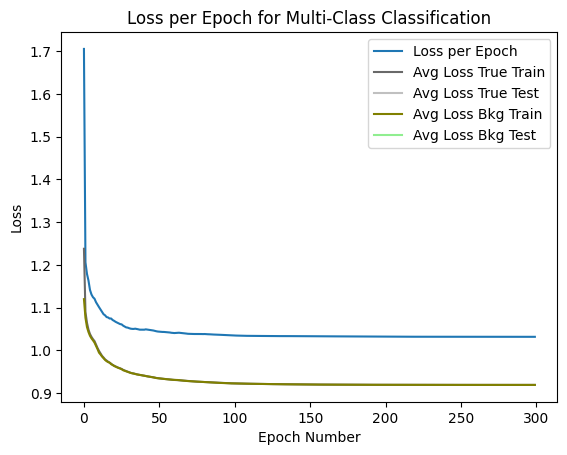

In [76]:
array_of_epochs = np.arange(len(loss_per_epoch))

plt.plot(array_of_epochs, loss_per_epoch, label='Loss per Epoch')
plt.plot(array_of_epochs, avg_loss_training_true_class,'dimgray', label='Avg Loss True Train')
plt.plot(array_of_epochs, avg_loss_testing_true_class,'silver', label='Avg Loss True Test')
plt.plot(array_of_epochs, avg_loss_training_bkg_classes,'olive', label='Avg Loss Bkg Train')
plt.plot(array_of_epochs, avg_loss_testing_bkg_classes,'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Multi-Class Classification")
plt.legend()
plt.show()

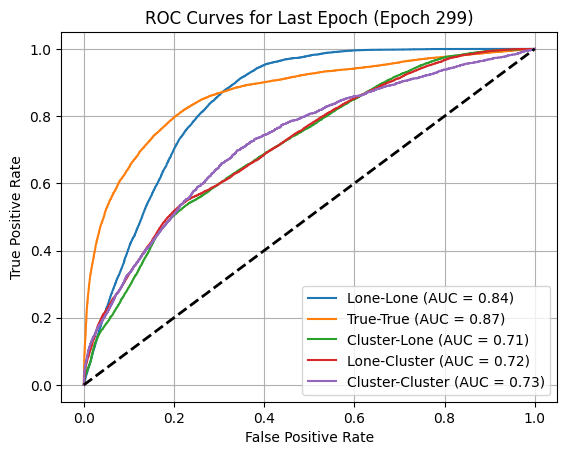

In [69]:
# Extract last epoch data (epoch 299)
epoch_idx = -1  # Last epoch
y_score = scores[epoch_idx]  # Shape (51000, 5)
y_true = truth_labels[epoch_idx]  # Shape (51000,)

# Class name mapping
class_names = {
    0: "Lone-Lone",
    1: "True-True",
    2: "Cluster-Lone",
    3: "Lone-Cluster",
    4: "Cluster-Cluster"
}

# Binarize the true labels for multi-class ROC calculation
num_classes = y_score.shape[1]
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Last Epoch (Epoch 299)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [104]:
# Define class names
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Extract last epoch data
epoch_index = -1  # Last epoch
epoch_scores = scores[epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = truth_labels[epoch_index]  # Shape: (24000,)

# Compute optimal thresholds using Youden's J statistic
optimal_thresholds = {}

for i, class_name in enumerate(class_names):
    y_true_binary = (epoch_truth_labels == i).astype(int)  # Convert to binary labels for ROC
    y_scores_class = epoch_scores[:, i]  # Scores for class i
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores_class)
    
    # Compute Youden’s J statistic
    J_scores = tpr - fpr
    optimal_idx = np.argmax(J_scores)  # Find the best threshold index
    optimal_thresholds[class_name] = thresholds[optimal_idx]  # Store the optimal threshold

# Print computed thresholds
print(f"Optimal Lone-Lone Threshold: {optimal_thresholds['Lone-Lone']:.3f}")
print(f"Optimal True-True Threshold: {optimal_thresholds['True-True']:.3f}")
print(f"Optimal Cluster-Lone Threshold: {optimal_thresholds['Cluster-Lone']:.3f}")
print(f"Optimal Lone-Cluster Threshold: {optimal_thresholds['Lone-Cluster']:.3f}")
print(f"Optimal Cluster-Cluster Threshold: {optimal_thresholds['Cluster-Cluster']:.3f}")

Optimal Lone-Lone Threshold: 0.515
Optimal True-True Threshold: 0.074
Optimal Cluster-Lone Threshold: 0.181
Optimal Lone-Cluster Threshold: 0.212
Optimal Cluster-Cluster Threshold: 0.033


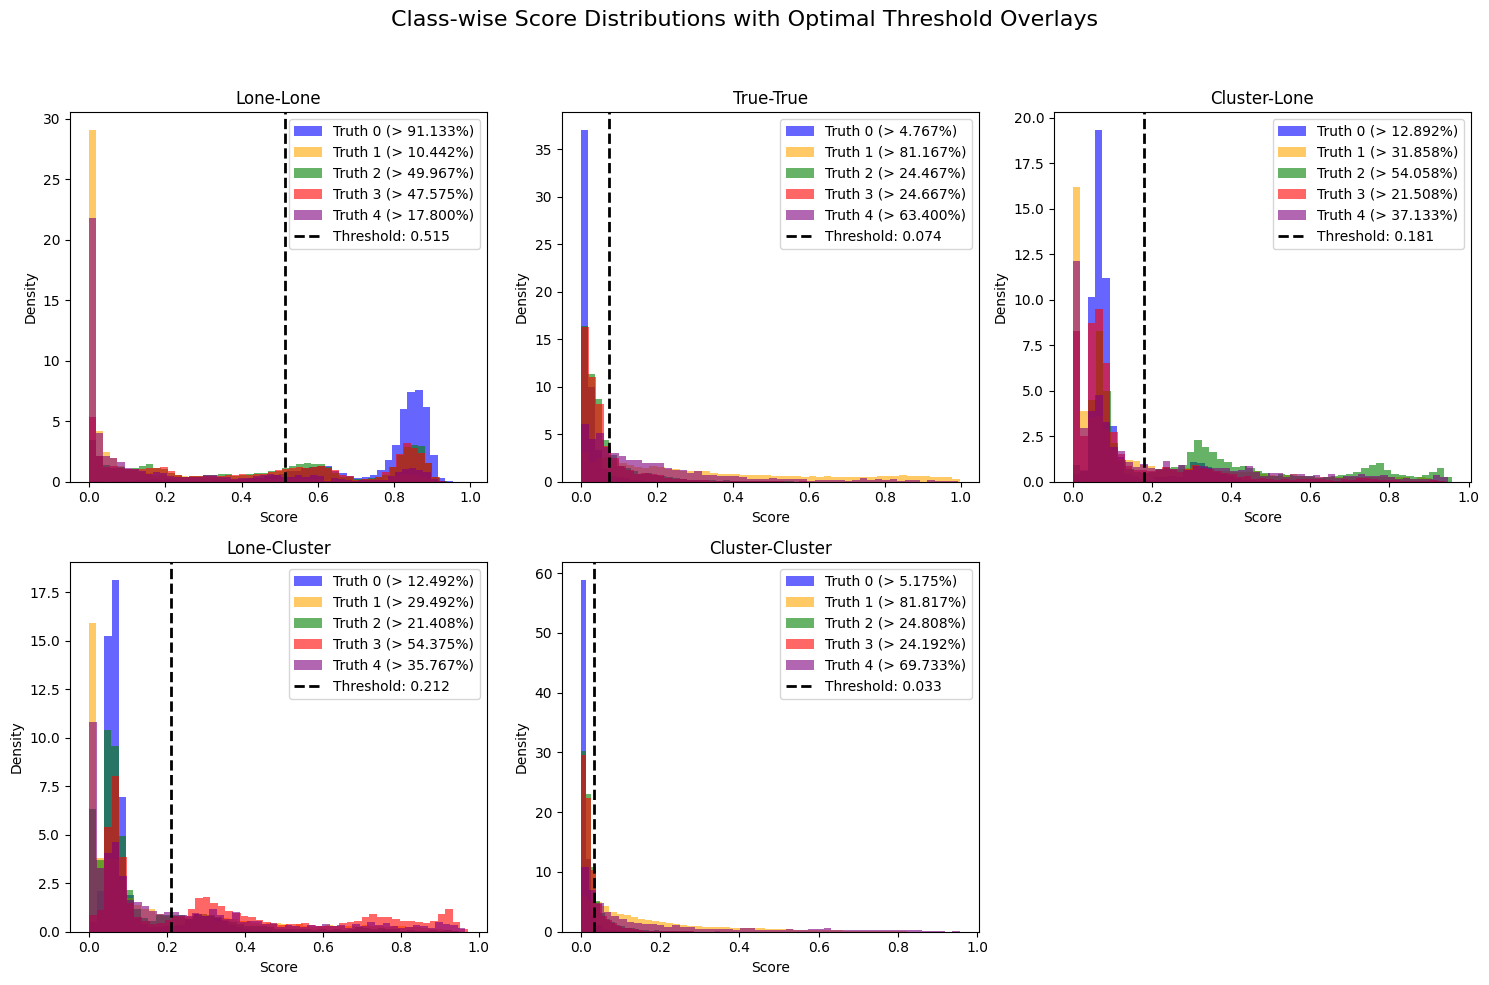

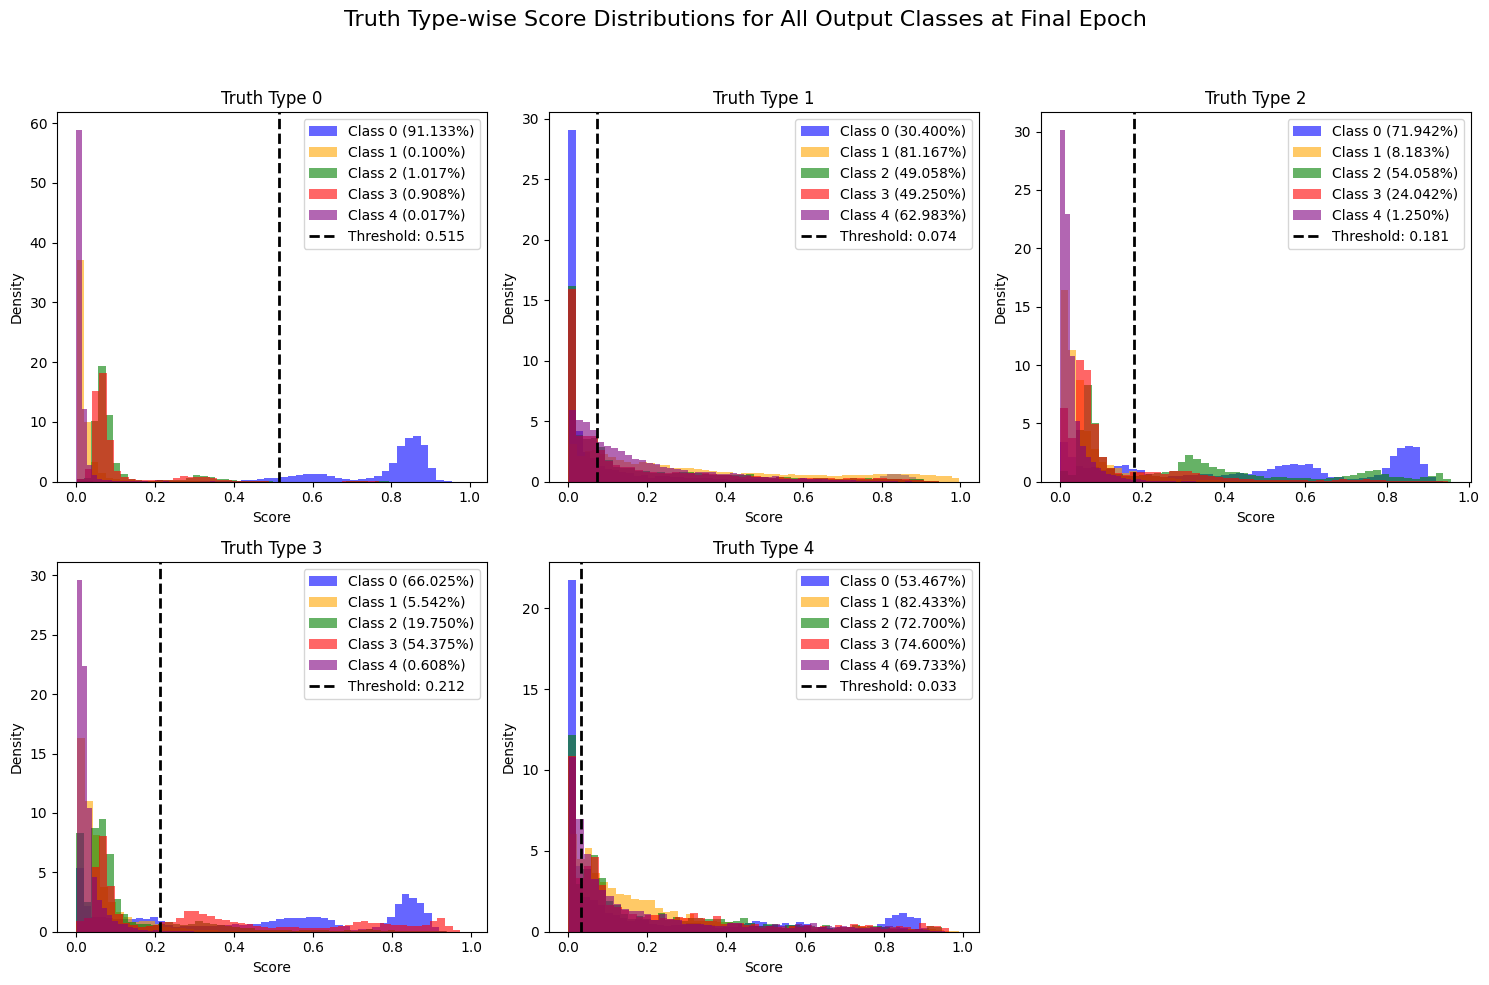

In [109]:
figsize = (15, 10)

# Class-wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    ax.set_title(f'{class_name}')  # Use class name instead of "Output Class {class_idx}"
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of samples with scores > optimal threshold
        if scores_for_truth_type.size > 0:  # Avoid issues with empty slices
            fraction_above_threshold = np.mean(scores_for_truth_type > optimal_thresh)
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (> {fraction_above_threshold:.3%})',
            color=colors[truth_type % len(colors)]
        )

    # Add vertical line for the optimal threshold
    ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_thresh:.3f}')

    ax.legend()

# Hide the extra subplot if the number of classes is less than total subplots
if len(axes) > len(class_names):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

# Truth-type wise score distributions
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

unique_truth_types = sorted(np.unique(epoch_truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    # Determine which class is associated with this truth type
    associated_class_name = class_names[truth_type]
    associated_class_idx = truth_type  # Since classes and truth types are aligned
    optimal_threshold = optimal_thresholds[associated_class_name]  # Get the threshold

    for class_idx, class_name in enumerate(class_names):
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels == truth_type, class_idx]

        # Calculate the fraction of scores above the associated class threshold
        if scores_for_truth_type_class.size > 0:
            fraction_above_threshold = np.mean(scores_for_truth_type_class > optimal_threshold) * 100
        else:
            fraction_above_threshold = 0.0  # Default if no samples exist

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} ({fraction_above_threshold:.3f}%)',
            color=colors[class_idx % len(colors)]
        )

    # Add threshold line ONLY for the associated class
    ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {optimal_threshold:.3f}')

    # Add legend with updated labels including fraction above threshold
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

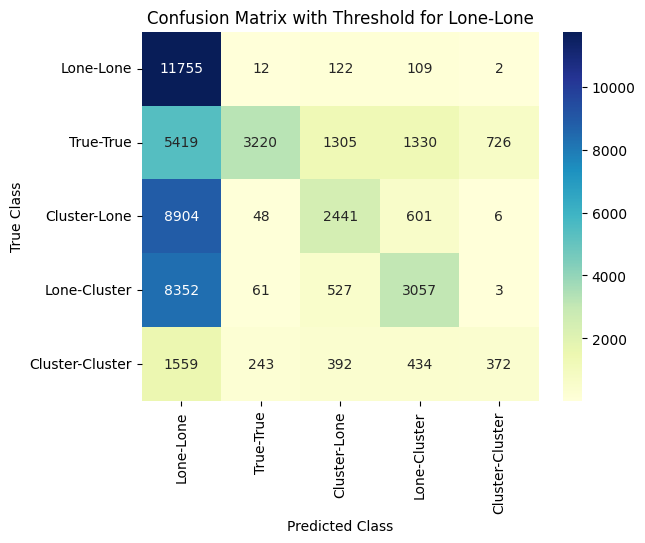

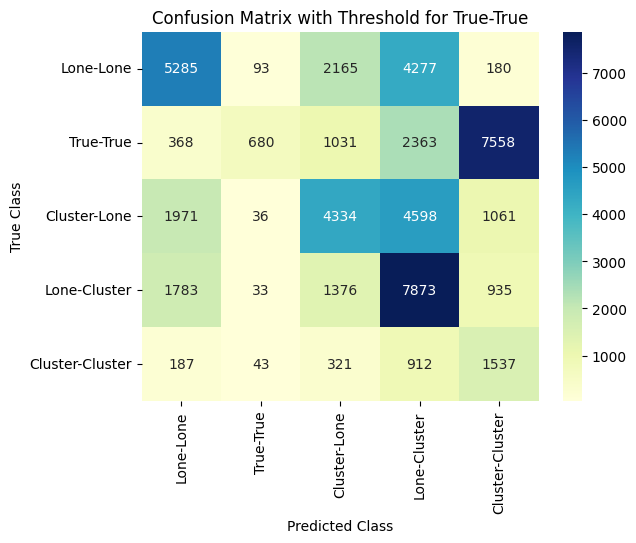

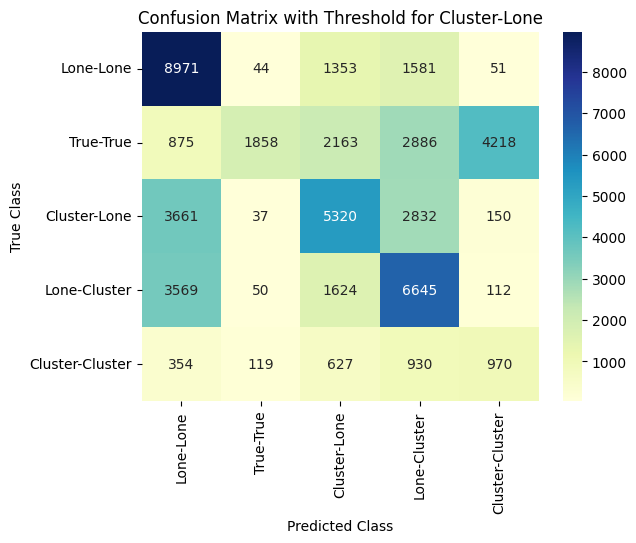

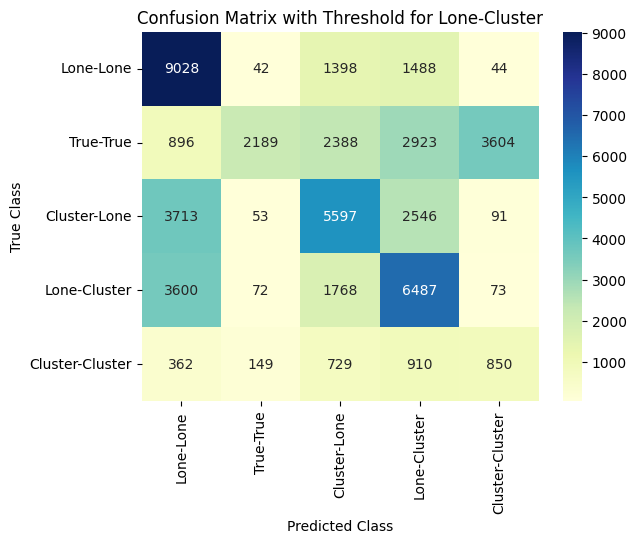

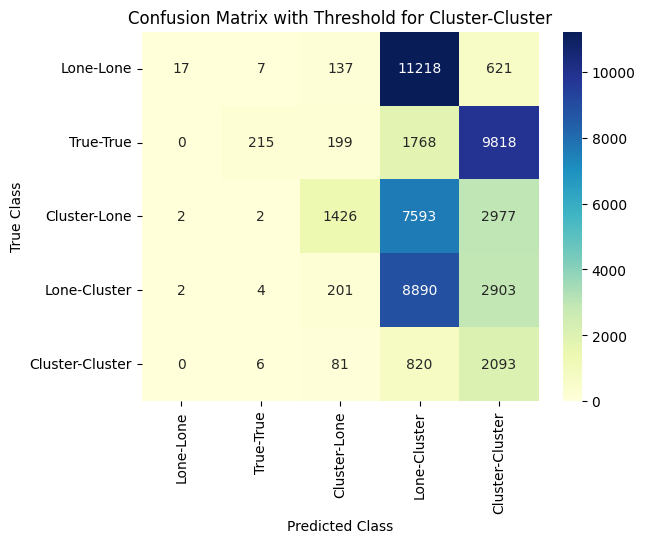

In [106]:
# Color map choice
cmap = 'YlGnBu'

# Create a plot for each class
for class_idx, class_name in enumerate(class_names):
    # Get the optimal threshold for this class
    optimal_thresh = optimal_thresholds[class_name]
    
    # Initialize predictions array for this class-based threshold
    y_pred = np.zeros_like(epoch_truth_labels)
    
    # Predict the class for each sample using only this class's threshold
    for class_idx_pred in range(len(class_names)):
        y_scores_class = epoch_scores[:, class_idx_pred]  # Scores for this class
        predicted_class = (y_scores_class >= optimal_thresh).astype(int)
        
        # Assign the predicted class to the sample for this class threshold
        y_pred[predicted_class == 1] = class_idx_pred
    
    # Generate the confusion matrix for this class-based threshold
    cm = confusion_matrix(epoch_truth_labels, y_pred)
    
    # Plot the confusion matrix using Seaborn
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix with Threshold for {class_name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()